In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

In [18]:
pip install pandas numpy matplotlib scikit-learn



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
data_dir = "PPMI_ds/"

files = {
    "diagnosis": "Primary_Clinical_Diagnosis_18Mar2025.csv",
    "parkinsonism": "Features_of_Parkinsonism_18Mar2025.csv",
    "rem": "Features_of_REM_Behavior_Disorder_18Mar2025.csv",
    "cgi": "Clinical_Global_Impression__CGI__-_Investigator_18Mar2025.csv",
    "exam": "General_Physical_Exam_18Mar2025.csv"
}

dfs = {name: pd.read_csv(f"{data_dir}/{fname}") for name, fname in files.items()}

# 🔹 Step 2: Clean general physical exam (pivot long format)
exam_df = dfs['exam'][['PATNO', 'PECAT', 'ABNORM']]
exam_wide = exam_df.pivot_table(index='PATNO', columns='PECAT', values='ABNORM', aggfunc='max')
exam_wide.columns = [f"ABNORM_{str(col).strip().replace(' ', '_')}" for col in exam_wide.columns]
exam_wide.reset_index(inplace=True)

# 🔹 Step 3: Prepare label (PRIMDIAG from diagnosis file)
label_df = dfs['diagnosis'][['PATNO', 'PRIMDIAG']].drop_duplicates(subset='PATNO')
label_df['label'] = label_df['PRIMDIAG'].apply(lambda x: 1 if x == 17 else 0)
label_df = label_df[['PATNO', 'label']]

# 🔹 Step 4: Process and aggregate other files (1 row per PATNO)
aggregated = []

for key in ['parkinsonism', 'rem', 'cgi']:
    df = dfs[key]
    df = df.drop(columns=[col for col in df.columns if col in ['EVENT_ID', 'INFODT', 'REC_ID', 'PAG_NAME', 'ORIG_ENTRY', 'LAST_UPDATE']], errors='ignore')
    df_grouped = df.groupby('PATNO').mean(numeric_only=True).reset_index()
    aggregated.append(df_grouped)

# 🔹 Step 5: Merge everything into one DataFrame
merged = label_df.copy()

for df in aggregated + [exam_wide]:
    merged = merged.merge(df, on='PATNO', how='left')

print("✅ Final merged shape:", merged.shape)
merged.to_csv("merged_clin.csv")

✅ Final merged shape: (4335, 22)


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


X = merged.drop(columns=['PATNO', 'label'])
y = merged['label']

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)

In [21]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
logreg_proba = logreg.predict_proba(X_test)[:, 1]

print("🔹 Logistic Regression")
print("✅ Accuracy:", accuracy_score(y_test, logreg_pred))
print("📈 ROC AUC:", roc_auc_score(y_test, logreg_proba))
print(classification_report(y_test, logreg_pred))

🔹 Logistic Regression
✅ Accuracy: 0.76239907727797
📈 ROC AUC: 0.8476518394441342
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       597
           1       0.61      0.67      0.64       270

    accuracy                           0.76       867
   macro avg       0.73      0.74      0.73       867
weighted avg       0.77      0.76      0.77       867



In [22]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]

print("\n🔹 Random Forest")
print("✅ Accuracy:", accuracy_score(y_test, rf_pred))
print("📈 ROC AUC:", roc_auc_score(y_test, rf_proba))
print(classification_report(y_test, rf_pred))


🔹 Random Forest
✅ Accuracy: 0.8050749711649365
📈 ROC AUC: 0.8724145418450276
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       597
           1       0.68      0.69      0.69       270

    accuracy                           0.81       867
   macro avg       0.77      0.77      0.77       867
weighted avg       0.81      0.81      0.81       867



In [23]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)
mlp_proba = mlp.predict_proba(X_test)[:, 1]

print("\n🔹 MLP Neural Network")
print("✅ Accuracy:", accuracy_score(y_test, mlp_pred))
print("📈 ROC AUC:", roc_auc_score(y_test, mlp_proba))
print(classification_report(y_test, mlp_pred))


🔹 MLP Neural Network
✅ Accuracy: 0.7889273356401384
📈 ROC AUC: 0.8450586264656615
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       597
           1       0.65      0.70      0.67       270

    accuracy                           0.79       867
   macro avg       0.75      0.77      0.76       867
weighted avg       0.79      0.79      0.79       867



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


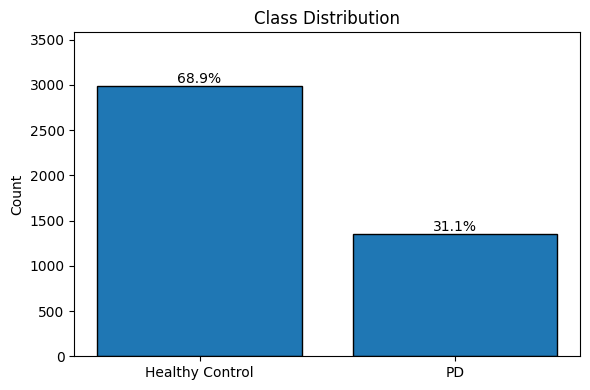

In [24]:
import matplotlib.pyplot as plt

# Use the y_test from previous context for class distribution
# For demo, assume y contains the full label array

# Simulate what y would look like
import numpy as np
from collections import Counter

# Reconstruct y as binary just for visualization
# Normally you'd pass your actual y Series here
# Assuming we already have 'y' from your session
try:
    label_counts = Counter(y)
except NameError:
    label_counts = Counter(y)

labels = ['Healthy Control', 'PD']
counts = [label_counts[0], label_counts[1]]
percentages = [count / sum(counts) * 100 for count in counts]

# Plotting
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, counts, edgecolor='black')
plt.title('Class Distribution')
plt.ylabel('Count')

# Annotate with percentage
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, f'{pct:.1f}%', 
             ha='center', va='bottom', fontsize=10)

plt.ylim(0, max(counts) * 1.2)
plt.tight_layout()
plt.show()


In [31]:
# Reshaping the data 
import numpy as np

# Assuming X is your feature matrix of shape (num_samples, num_features)
# and you decide on a sequence length
sequence_length = 1  # Adjust based on your data
input_size = X.shape[1] // sequence_length

# Reshape X to (num_samples, sequence_length, input_size)
X_reshaped = X.values.reshape(-1, sequence_length, input_size)


In [43]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Step 1: Reshape for RNN input — add a dummy sequence length dimension
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Step 2: Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Step 3: Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Step 4: Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Optional: check shapes
print(f"Train input shape: {X_train_tensor.shape}")
print(f"Val input shape:   {X_test_tensor.shape}")


Train input shape: torch.Size([3468, 1, 20])
Val input shape:   torch.Size([867, 1, 20])


In [44]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1, output_size=2):
        super(RNNModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # use last time step
        return out


In [45]:
import torch
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set hyperparameters
input_size = X_train.shape[2]  # number of features
hidden_size = 64
num_layers = 1
output_size = 2
num_epochs = 20
learning_rate = 0.001

# Initialize model
model = RNNModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_losses = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation loop
    model.eval()
    val_losses = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_losses.append(val_loss.item())

            _, preds = torch.max(val_outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())

    val_acc = accuracy_score(all_labels, all_preds)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {sum(train_losses)/len(train_losses):.4f} "
          f"- Val Loss: {sum(val_losses)/len(val_losses):.4f} - Val Acc: {val_acc:.4f}")


Epoch 1/20 - Train Loss: 0.5469 - Val Loss: 0.4312 - Val Acc: 0.7612
Epoch 2/20 - Train Loss: 0.4238 - Val Loss: 0.4160 - Val Acc: 0.7647
Epoch 3/20 - Train Loss: 0.4144 - Val Loss: 0.4116 - Val Acc: 0.7739
Epoch 4/20 - Train Loss: 0.4092 - Val Loss: 0.4075 - Val Acc: 0.7716
Epoch 5/20 - Train Loss: 0.4060 - Val Loss: 0.4052 - Val Acc: 0.7647
Epoch 6/20 - Train Loss: 0.4031 - Val Loss: 0.4031 - Val Acc: 0.7774
Epoch 7/20 - Train Loss: 0.4006 - Val Loss: 0.4026 - Val Acc: 0.7774
Epoch 8/20 - Train Loss: 0.3953 - Val Loss: 0.4006 - Val Acc: 0.7785
Epoch 9/20 - Train Loss: 0.3932 - Val Loss: 0.4014 - Val Acc: 0.7751
Epoch 10/20 - Train Loss: 0.3900 - Val Loss: 0.4012 - Val Acc: 0.7762
Epoch 11/20 - Train Loss: 0.3877 - Val Loss: 0.4012 - Val Acc: 0.7774
Epoch 12/20 - Train Loss: 0.3872 - Val Loss: 0.4066 - Val Acc: 0.7774
Epoch 13/20 - Train Loss: 0.3849 - Val Loss: 0.4051 - Val Acc: 0.7832
Epoch 14/20 - Train Loss: 0.3825 - Val Loss: 0.4043 - Val Acc: 0.7751
Epoch 15/20 - Train Loss: 0.3

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Evaluate on validation set
model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Get predicted class
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())

        # Get raw probabilities for AUC
        probs = torch.softmax(outputs, dim=1)[:, 1]  # PD = class 1
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy & report
print("✅ Final Evaluation on Validation Set")
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Control", "PD"]))

# AUC
auc_score = roc_auc_score(all_labels, all_probs)
print(f"AUC-ROC: {auc_score:.4f}")


✅ Final Evaluation on Validation Set
Confusion Matrix:
[[484 113]
 [ 67 203]]

Classification Report:
              precision    recall  f1-score   support

     Control       0.88      0.81      0.84       597
          PD       0.64      0.75      0.69       270

    accuracy                           0.79       867
   macro avg       0.76      0.78      0.77       867
weighted avg       0.80      0.79      0.80       867

AUC-ROC: 0.8696
